# Chapter 12

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# check if the libraries we need are installed

try:
    import pint
except ImportError:
    !pip install pint
    
try:
    from modsim import *
except ImportError:
    !pip install modsimpy

### Code

Here's the code from the previous notebook that we'll need.

In [2]:
from modsim import State, System

def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [3]:
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    t: time step
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [4]:
from numpy import arange

def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.loc[system.t0] = system.init
    
    for t in arange(system.t0, system.t_end):
        frame.loc[t+1] = update_func(frame.loc[t], t, system)
    
    return frame

In the previous chapter I presented the SIR model of infectious disease and used it to model the Freshman Plague at Olin. In this chapter we'll consider metrics intended to quantify the effects of the disease and interventions intended to reduce those effects.

## Immunization

Models like this are useful for testing "what if?" scenarios. As an
example, we'll consider the effect of immunization.

Suppose there is a vaccine that causes a student to become immune to the Freshman Plague without being infected. How might you modify the model to capture this effect?

One option is to treat immunization as a shortcut from susceptible to
recovered without going through infectious. We can implement this
feature like this:

In [6]:
def add_immunization(system, fraction):
    system.init.S -= fraction
    system.init.R += fraction

`add_immunization` moves the given fraction of the population from `S`
to `R`. 

In [14]:
tc = 3             # time between contacts in days 
tr = 4             # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)
results = run_simulation(system, update_func)

If we assume that 10% of students are vaccinated at the
beginning of the semester, and the vaccine is 100% effective, we can
simulate the effect like this:

In [17]:
system2 = make_system(beta, gamma)
add_immunization(system2, 0.1)
results2 = run_simulation(system2, update_func)

The following figure shows `S` as a function of time, with and
without immunization.

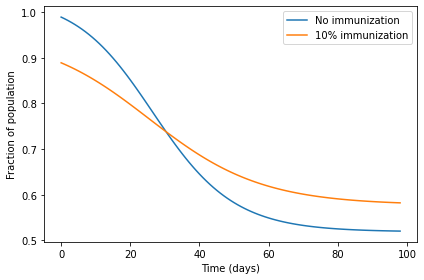

In [22]:
results.S.plot(label='No immunization')
results2.S.plot(label='10% immunization')

decorate(xlabel='Time (days)',
         ylabel='Fraction of population')

## Metrics

When we plot a time series, we get a view of everything that happened
when the model ran, but often we want to boil it down to a few numbers
that summarize the outcome. These summary statistics are called
**metrics**, as we saw in Section xxx.

In the SIR model, we might want to know the time until the peak of the
outbreak, the number of people who are sick at the peak, the number of
students who will still be sick at the end of the semester, or the total number of students who get sick at any point.

As an example, I will focus on the last one --- the total number of sick students --- and we will consider interventions intended to minimize it.

When a person gets infected, they move from `S` to `I`, so we can get
the total number of infections by computing the difference in `S` at the beginning and the end:

In [15]:
def calc_total_infected(results, system):
    s_0 = results.S[system.t0]
    s_end = results.S[system.t_end]
    return s_0 - s_end

In [16]:
calc_total_infected(results, system)

0.468320811028781

In [23]:
calc_total_infected(results2, system2)

0.30650802853979753

Without immunization, almost 47% of the population gets infected at some point. With 10% immunization, only 31% get infected. That's pretty good.

## Sweeping Immunization

Now let's see what happens if we administer more vaccines. This
following function sweeps a range of immunization rates:

In [24]:
def sweep_immunity(immunize_array):
    sweep = SweepSeries()

    for fraction in immunize_array:
        sir = make_system(beta, gamma)
        add_immunization(sir, fraction)
        results = run_simulation(sir, update_func)
        sweep[fraction] = calc_total_infected(results, sir)

    return sweep

The parameter of `sweep_immunity` is an array of immunization rates. The
result is a `SweepSeries` object that maps from each immunization rate
to the resulting fraction of students ever infected.

The following figure shows a plot of the `SweepSeries`. Notice that
the x-axis is the immunization rate, not time.

In [26]:
immunize_array = linspace(0, 1, 21)
infected_sweep = sweep_immunity(immunize_array)

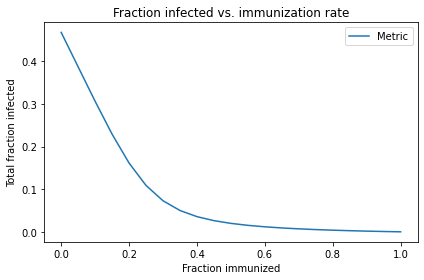

In [28]:
infected_sweep.plot()

decorate(xlabel='Fraction immunized',
         ylabel='Total fraction infected',
         title='Fraction infected vs. immunization rate')

As the immunization rate increases, the number of infections drops
steeply. If 40% of the students are immunized, fewer than 4% get sick.
That's because immunization has two effects: it protects the people who get immunized (of course) but it also protects the rest of the
population.

Reducing the number of "susceptibles" and increasing the number of
"resistants" makes it harder for the disease to spread, because some
fraction of contacts are wasted on people who cannot be infected. This
phenomenon is called **herd immunity**, and it is an important element
of public health (see <http://modsimpy.com/herd>).

The steepness of the curve is a blessing and a curse. It's a blessing
because it means we don't have to immunize everyone, and vaccines can
protect the "herd" even if they are not 100% effective.

But it's a curse because a small decrease in immunization can cause a
big increase in infections. In this example, if we drop from 80%
immunization to 60%, that might not be too bad. But if we drop from 40% to 20%, that would trigger a major outbreak, affecting more than 15% of the population. For a serious disease like measles, just to name one, that would be a public health catastrophe.

One use of models like this is to demonstrate phenomena like herd
immunity and to predict the effect of interventions like vaccination.
Another use is to evaluate alternatives and guide decision making. We'll see an example in the next section.

## Hand washing

Suppose you are the Dean of Student Life, and you have a budget of just \$1200 to combat the Freshman Plague. You have two options for spending this money:

1.  You can pay for vaccinations, at a rate of \$100 per dose.

2.  You can spend money on a campaign to remind students to wash hands
    frequently.

We have already seen how we can model the effect of vaccination. Now
let's think about the hand-washing campaign. We'll have to answer two
questions:

1.  How should we incorporate the effect of hand washing in the model?

2.  How should we quantify the effect of the money we spend on a
    hand-washing campaign?

For the sake of simplicity, let's assume that we have data from a
similar campaign at another school showing that a well-funded campaign
can change student behavior enough to reduce the infection rate by 20%.

In terms of the model, hand washing has the effect of reducing `beta`.
That's not the only way we could incorporate the effect, but it seems
reasonable and it's easy to implement.

Now we have to model the relationship between the money we spend and the
effectiveness of the campaign. Again, let's suppose we have data from
another school that suggests:

-   If we spend \$500 on posters, materials, and staff time, we can
    change student behavior in a way that decreases the effective value of `beta` by 10%.

-   If we spend \$1000, the total decrease in `beta` is almost 20%.

-   Above \$1000, additional spending has little additional benefit.

### Logistic function

To model the effect of a hand-washing campaign, I'll use a [generalized logistic function](https://en.wikipedia.org/wiki/Generalised_logistic_function) (GLF), which is a convenient function for modeling curves that have a generally sigmoid shape.  The parameters of the GLF correspond to various features of the curve in a way that makes it easy to find a function that has the shape you want, based on data or background information about the scenario.

In [33]:
from numpy import exp

def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.
    
    A: controls the lower bound
    B: controls the steepness of the transition 
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition
    
    returns: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q * exp(exponent)
    return A + (K-A) / denom ** (1/nu)

The following array represents the range of possible spending.

In [34]:
spending = linspace(0, 1200, 21)

`compute_factor` computes the reduction in `beta` for a given level of campaign spending.

`M` is chosen so the transition happens around \$500.

`K` is the maximum reduction in `beta`, 20%.

`B` is chosen by trial and error to yield a curve that seems feasible.

In [35]:
def compute_factor(spending):
    """Reduction factor as a function of spending.
    
    spending: dollars from 0 to 1200
    
    returns: fractional reduction in beta
    """
    return logistic(spending, M=500, K=0.2, B=0.01)

Here's what it looks like.

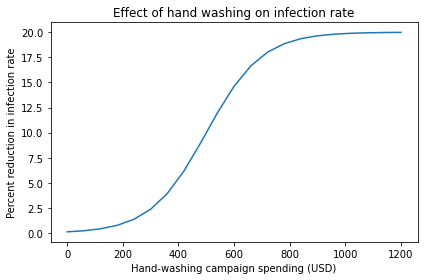

In [37]:
percent_reduction = compute_factor(spending) * 100

plot(spending, percent_reduction)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of hand washing on infection rate')

The result is the following function, which
takes spending as a parameter and returns `factor`, which is the factor
by which `beta` is reduced:

In [38]:
def compute_factor(spending):
    return logistic(spending, M=500, K=0.2, B=0.01)

I use `compute_factor` to write `add_hand_washing`, which takes a
`System` object and a budget, and modifies `system.beta` to model the
effect of hand washing:

In [39]:
def add_hand_washing(system, spending):
    factor = compute_factor(spending)
    system.beta *= (1 - factor)

Now we can sweep a range of values for `spending` and use the simulation
to compute the effect:

In [57]:
def sweep_hand_washing(spending_array):
    sweep = SweepSeries()
    
    for spending in spending_array:
        system = make_system(beta, gamma)
        add_hand_washing(system, spending)
        results = run_simulation(system, update_func)
        sweep[spending] = calc_total_infected(results, system)
        
    return sweep

Here's how we run it:

In [58]:
from numpy import linspace

spending_array = linspace(0, 1200, 20)
infected_sweep2 = sweep_hand_washing(spending_array)

The following figure shows the result. 

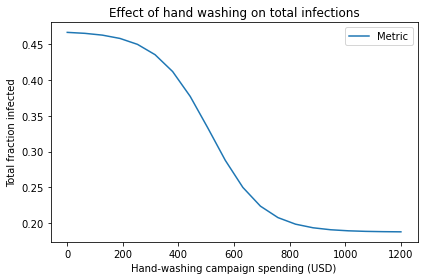

In [61]:
infected_sweep2.plot()

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Total fraction infected',
         title='Effect of hand washing on total infections')

Below \$200, the campaign has little effect. 

At \$800 it has a substantial effect, reducing total infections from more than 45% to about 20%. 

Above \$800, the additional benefit is small.

## Optimization

Let's put it all together. With a fixed budget of \$1200, we have to
decide how many doses of vaccine to buy and how much to spend on the
hand-washing campaign.

Here are the parameters:

In [43]:
num_students = 90
budget = 1200
price_per_dose = 100
max_doses = int(budget / price_per_dose)

The fraction `budget/price_per_dose` might not be an integer. `int` is a
built-in function that converts numbers to integers, rounding down.

We'll sweep the range of possible doses:

In [47]:
dose_array = arange(max_doses+1)

In this example we call `linrange` with only one argument; it returns a
NumPy array with the integers from 0 to `max_doses`. With the argument
`endpoint=True`, the result includes both endpoints.

Then we run the simulation for each element of `dose_array`:

In [50]:
def sweep_doses(dose_array):
    sweep = SweepSeries()
    
    for doses in dose_array:
        fraction = doses / num_students
        spending = budget - doses * price_per_dose
        
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        add_hand_washing(system, spending)
        
        results = run_simulation(system, update_func)
        sweep[doses] = calc_total_infected(results, system)

    return sweep

For each number of doses, we compute the fraction of students we can
immunize, `fraction` and the remaining budget we can spend on the
campaign, `spending`. Then we run the simulation with those quantities
and store the number of infections.

The following figure shows the result.

In [51]:
infected_sweep3 = sweep_doses(dose_array)

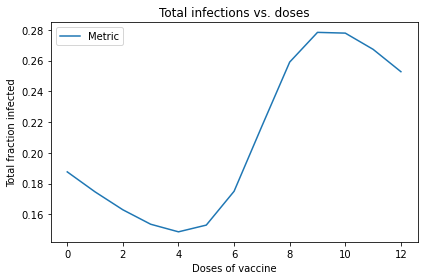

In [52]:
infected_sweep3.plot()

decorate(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses')

If we buy no doses of vaccine and spend the entire budget on the campaign, the fraction infected is around 19%. At 4 doses, we have \$800 left for the campaign, and this is the optimal point that minimizes the number of students who get sick.

As we increase the number of doses, we have to cut campaign spending,
which turns out to make things worse. But interestingly, when we get
above 10 doses, the effect of herd immunity starts to kick in, and the
number of sick students goes down again.

## Summary

### Exercises

**Exercise:** Suppose the price of the vaccine drops to $50 per dose.  How does that affect the optimal allocation of the spending?

**Exercise:** Suppose we have the option to quarantine infected students.  For example, a student who feels ill might be moved to an infirmary, or a private dorm room, until they are no longer infectious.

How might you incorporate the effect of quarantine in the SIR model?

In [ ]:
# Solution

"""There is no unique best answer to this question,
but one simple option is to model quarantine as an
effective reduction in gamma, on the assumption that
quarantine reduces the number of infectious contacts
per infected student.

Another option would be to add a fourth compartment
to the model to track the fraction of the population
in quarantine at each point in time.  This approach
would be more complex, and it is not obvious that it
is substantially better.

The following function could be used, like 
add_immunization and add_hand_washing, to adjust the
parameters in order to model various interventions.

In this example, `high` is the highest duration of
the infection period, with no quarantine.  `low` is
the lowest duration, on the assumption that it takes
some time to identify infectious students.

`fraction` is the fraction of infected students who 
are quarantined as soon as they are identified.
"""

def add_quarantine(system, fraction):
    """Model the effect of quarantine by adjusting gamma.
    
    system: System object
    fraction: fraction of students quarantined
    """
    # `low` represents the number of days a student 
    # is infectious if quarantined.
    # `high` is the number of days they are infectious
    # if not quarantined
    low = 1
    high = 4
    tr = high - fraction * (high-low)
    system.gamma = 1 / tr